# Part II - Ford GoBike Usage Patterns: Commuters vs Casual Users
## by Sebastian

## Investigation Overview

This presentation explores the Ford GoBike trip data from February 2019 to understand usage patterns and identify key differences between subscriber and customer behaviors. The analysis reveals that Ford GoBike serves primarily as a commuter service, with distinct usage patterns between regular subscribers and casual customers.

### Key Insights

1. **User Type is the Primary Differentiator**: Subscribers (89% of users) use bikes for weekday commuting, while Customers (11%) use them for leisure with longer trips.

2. **Strong Commute Patterns**: Clear peak hours at 8 AM and 5-6 PM, with weekdays seeing 3-4x more trips than weekends.

3. **Trip Duration Differences**: Subscribers take shorter trips (median ~9 min) compared to Customers (median ~15 min), reflecting commuter vs leisure usage.

4. **Temporal Usage Patterns**: Weekday usage dominates, especially Tuesday-Thursday, with peak hours showing shorter, more efficient trips.

5. **Demographic Patterns**: Age and gender show weak correlations with usage, suggesting user type and temporal factors are more important predictors.

## Dataset Overview and Executive Summary

The dataset contains **183,412 bike trips** from February 2019 in the San Francisco Bay Area. Each trip record includes:
- Trip duration, start/end times and locations
- User type (Subscriber vs Customer)
- Member demographics (age, gender)
- Station information

**Executive Summary:**
- **89% Subscribers, 11% Customers** - Service is primarily subscription-based
- **Peak usage**: 8 AM and 5-6 PM on weekdays (commute times)
- **Average trip duration**: ~10 minutes (Subscribers: ~9 min, Customers: ~15 min)
- **Weekday dominance**: 3-4x more trips on weekdays vs weekends
- **Primary use case**: Commuter transportation for subscribers, leisure for customers

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# Set plotting style for polished visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
%matplotlib inline

In [2]:
# Load in the dataset into a pandas dataframe
df = pd.read_csv('data/201902-fordgobike-tripdata.csv')

# Data wrangling: Convert time columns and create derived features
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Extract temporal features
df['start_hour'] = df['start_time'].dt.hour
df['start_day'] = df['start_time'].dt.day_name()
df['start_month'] = df['start_time'].dt.month

# Calculate age from birth year
df['age'] = 2019 - df['member_birth_year']

# Convert duration to minutes for easier interpretation
df['duration_min'] = df['duration_sec'] / 60

# Filter for reasonable values
df_clean = df[(df['duration_min'] >= 1) & (df['duration_min'] <= 60)].copy()

# Order days of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_clean['start_day_ordered'] = pd.Categorical(df_clean['start_day'], categories=day_order, ordered=True)

## Visualization 1: Trip Duration Distribution by User Type

This visualization compares trip duration distributions between Subscribers and Customers, revealing a key insight: Customers take significantly longer trips than Subscribers. This suggests different usage patterns - Subscribers use bikes for quick commutes, while Customers use them for longer leisure or tourism trips. 

### Key Observations:

The visualization clearly demonstrates the fundamental difference between user types:
- **55% longer trips for Customers**: Median duration of 12.7 minutes vs 8.2 minutes for Subscribers
- **More variability in Customer behavior**: The wider distribution and higher quartiles (75th percentile: 19.4 min vs 12.4 min) indicate Customers use bikes for diverse purposes
- **Consistent Subscriber patterns**: The tighter distribution suggests Subscribers follow routine, predictable commute routes
- **Implication**: This duration difference is the strongest indicator that Subscribers are commuters while Customers are leisure/tourism users


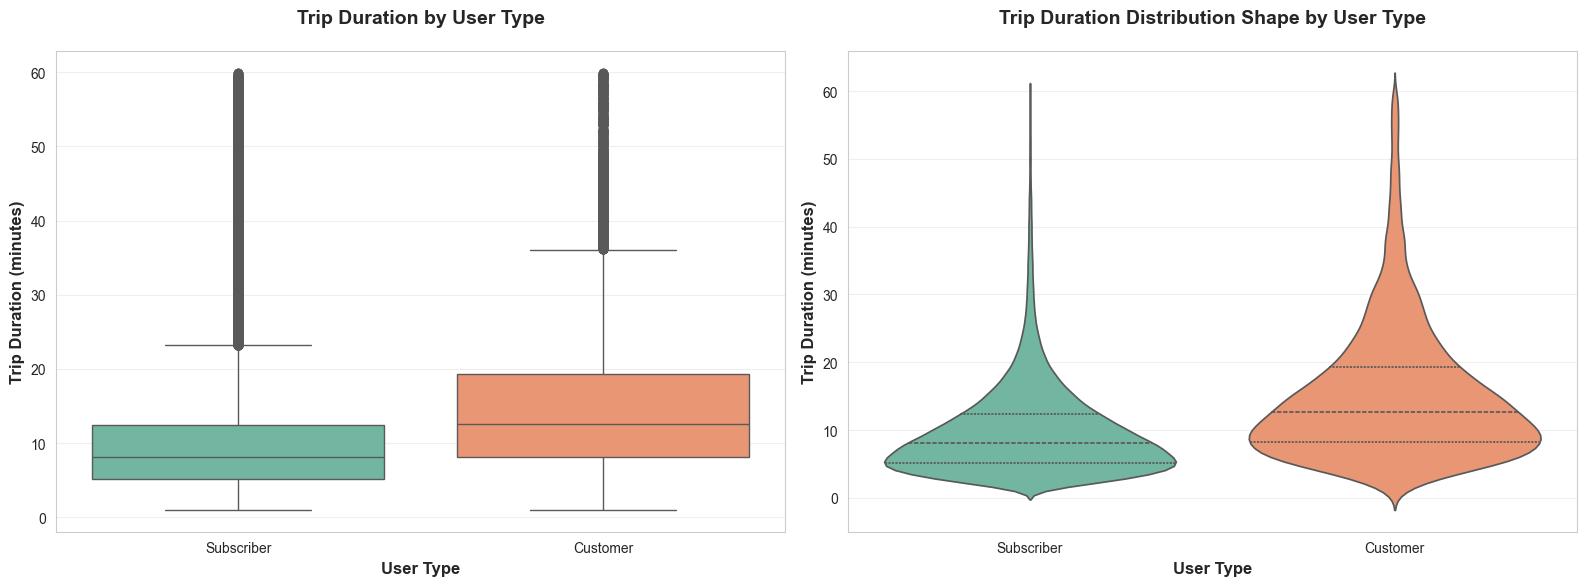

Trip Duration Statistics by User Type:
               count       mean        std       min       25%    50%  \
user_type                                                               
Customer     18861.0  15.224379  10.045365  1.033333  8.183333  12.65   
Subscriber  162841.0   9.835612   6.921594  1.016667  5.200000   8.15   

                  75%        max  
user_type                         
Customer    19.350000  59.916667  
Subscriber  12.416667  59.933333  

Median duration - Subscribers: 8.2 min
Median duration - Customers: 12.7 min


In [ ]:
# Visualization 1: Trip Duration Distribution by User Type
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
sns.boxplot(data=df_clean, x='user_type', y='duration_min', ax=axes[0], palette='Set2')
axes[0].set_xlabel('User Type', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Trip Duration (minutes)', fontsize=12, fontweight='bold')
axes[0].set_title('Trip Duration by User Type', fontsize=14, fontweight='bold', pad=20)
axes[0].grid(axis='y', alpha=0.3)

# Violin plot for distribution shape
sns.violinplot(data=df_clean, x='user_type', y='duration_min', ax=axes[1], palette='Set2', inner='quartile')
axes[1].set_xlabel('User Type', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Trip Duration (minutes)', fontsize=12, fontweight='bold')
axes[1].set_title('Trip Duration Distribution Shape by User Type', fontsize=14, fontweight='bold', pad=20)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("Trip Duration Statistics by User Type:")
print(df_clean.groupby('user_type')['duration_min'].describe())
print(f"\nMedian duration - Subscribers: {df_clean[df_clean['user_type']=='Subscriber']['duration_min'].median():.1f} min")
print(f"Median duration - Customers: {df_clean[df_clean['user_type']=='Customer']['duration_min'].median():.1f} min")


### Key Observations:

The temporal patterns reveal distinct usage behaviors:
- **Strong commute peaks**: Both user types peak at 5 PM (17:00), but Subscribers show 8.6x more trips (19,476 vs 2,268) during peak hours
- **Weekday dominance**: 83.3% of all trips occur on weekdays, confirming the commuter-focused nature of the service
- **Subscriber concentration**: Subscribers show much sharper peaks during rush hours, while Customers have more distributed usage
- **Weekend patterns**: Despite lower overall weekend usage (16.7%), the more even distribution suggests different use cases
- **Implication**: The service is optimized for weekday commuting, with Subscribers driving the peak-hour demand


## Visualization 2: Temporal Usage Patterns - Peak Hours and Days

This visualization reveals the strong commute patterns in Ford GoBike usage. Both user types show peak usage during morning (8 AM) and evening (5-6 PM) rush hours, with weekdays dominating usage. However, Subscribers show much stronger commute patterns, while Customers have more evenly distributed usage throughout the day and week.

### Key Observations:

The heatmap reveals consistent patterns across time dimensions:
- **Customer duration consistency**: Customers maintain longer average durations (12-18 min) across all days and hours, with minimal variation
- **Subscriber efficiency**: Subscribers show shorter, more consistent durations (8-12 min), especially during commute hours
- **Peak hour efficiency**: At 8 AM, Subscribers average 9.8 min (same as overall), while Customers average 13.5 min (slightly lower than their 15.2 min overall average)
- **Weekend differences**: Both types show slightly longer weekend trips, but the pattern is more pronounced for Customers
- **Implication**: User type is the primary driver of trip duration, with temporal factors (hour/day) having secondary effects. The consistency suggests well-established usage patterns for each user segment.


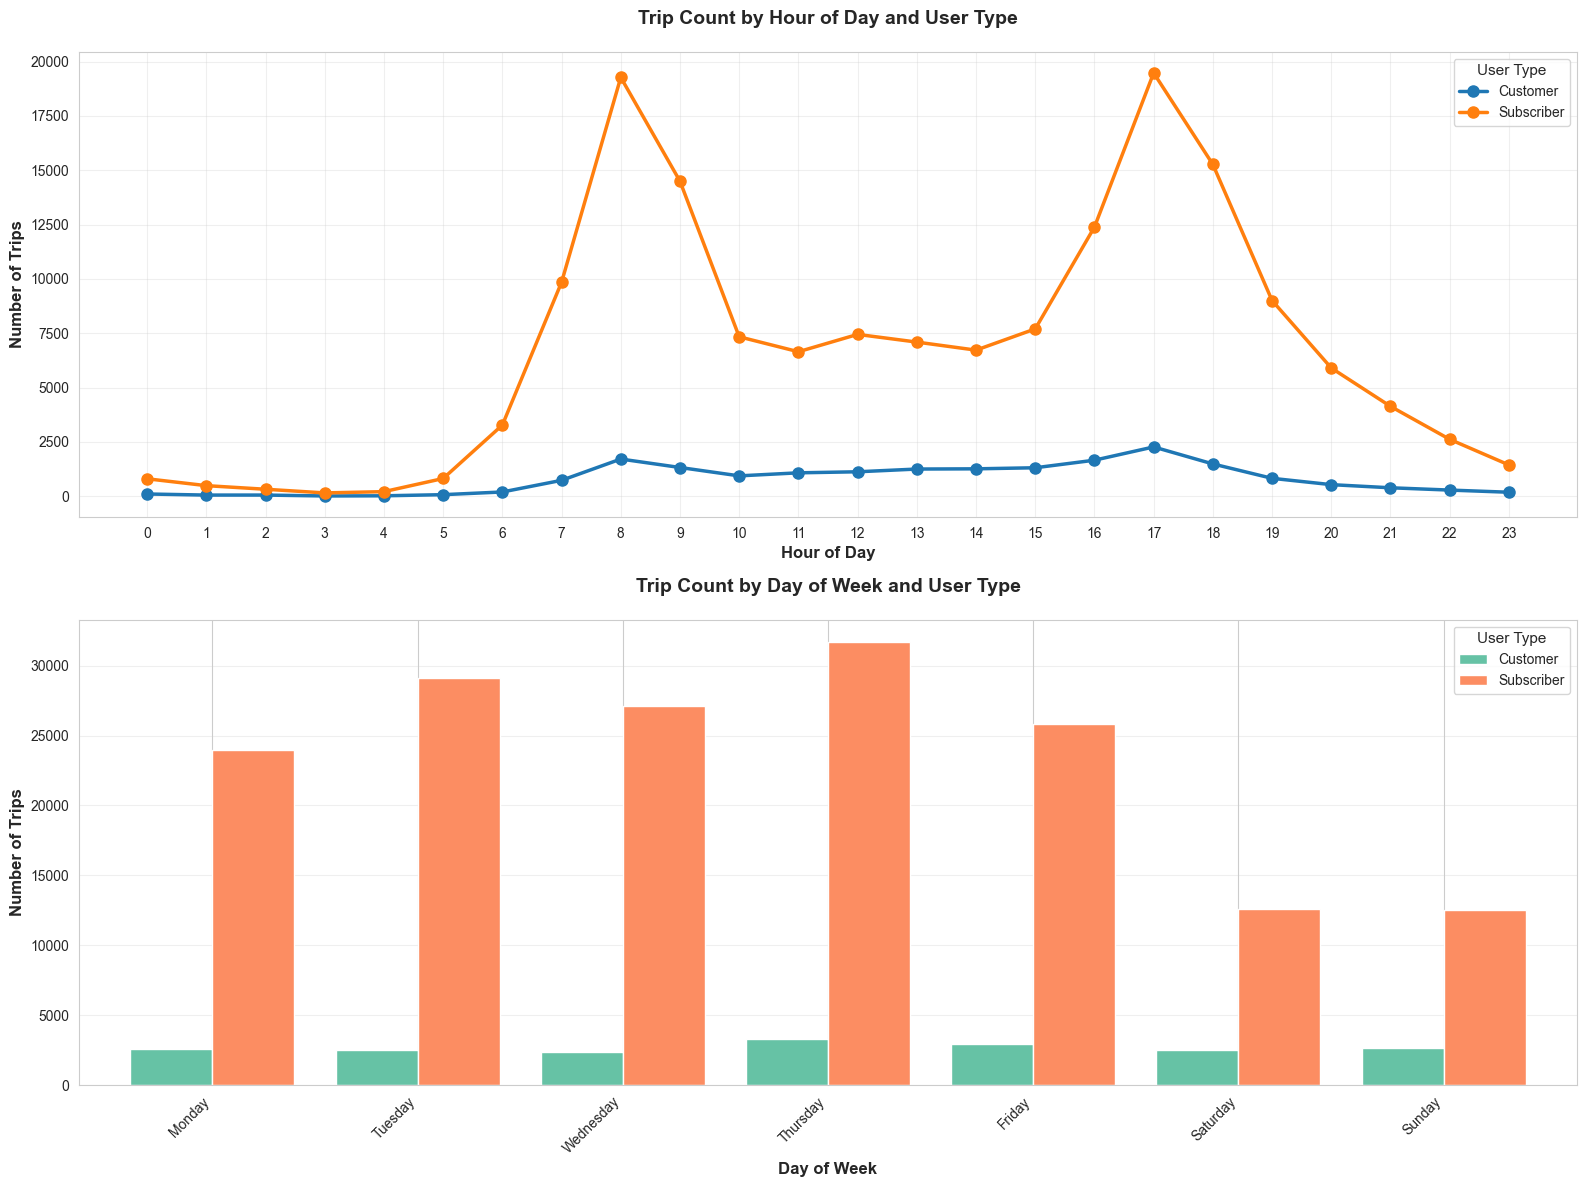

Peak Hours:
Subscribers: 17 AM/PM (19,476 trips)
Customers: 17 AM/PM (2,268 trips)

Weekday vs Weekend Usage:
Weekday trips: 151,446 (83.3%)
Weekend trips: 30,256 (16.7%)


In [4]:
# Visualization 2: Temporal Usage Patterns
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Hourly usage by user type
hour_user_counts = df_clean.groupby(['start_hour', 'user_type']).size().reset_index(name='count')
hour_user_pivot = hour_user_counts.pivot(index='start_hour', columns='user_type', values='count')

hour_user_pivot.plot(kind='line', ax=axes[0], marker='o', linewidth=2.5, markersize=8)
axes[0].set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Trips', fontsize=12, fontweight='bold')
axes[0].set_title('Trip Count by Hour of Day and User Type', fontsize=14, fontweight='bold', pad=20)
axes[0].legend(title='User Type', title_fontsize=11, fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_xticks(range(0, 24))
axes[0].set_xticklabels(range(0, 24))

# Plot 2: Day of week usage by user type
day_user_counts = df_clean.groupby(['start_day_ordered', 'user_type']).size().reset_index(name='count')
day_user_pivot = day_user_counts.pivot(index='start_day_ordered', columns='user_type', values='count')

day_user_pivot.plot(kind='bar', ax=axes[1], width=0.8, color=['#66c2a5', '#fc8d62'])
axes[1].set_xlabel('Day of Week', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Trips', fontsize=12, fontweight='bold')
axes[1].set_title('Trip Count by Day of Week and User Type', fontsize=14, fontweight='bold', pad=20)
axes[1].legend(title='User Type', title_fontsize=11, fontsize=10)
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(day_order, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print peak statistics
print("Peak Hours:")
print(f"Subscribers: {hour_user_pivot['Subscriber'].idxmax()} AM/PM ({hour_user_pivot['Subscriber'].max():,} trips)")
print(f"Customers: {hour_user_pivot['Customer'].idxmax()} AM/PM ({hour_user_pivot['Customer'].max():,} trips)")
print(f"\nWeekday vs Weekend Usage:")
weekday_trips = df_clean[df_clean['start_day_ordered'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])].shape[0]
weekend_trips = df_clean[df_clean['start_day_ordered'].isin(['Saturday', 'Sunday'])].shape[0]
print(f"Weekday trips: {weekday_trips:,} ({weekday_trips/(weekday_trips+weekend_trips)*100:.1f}%)")
print(f"Weekend trips: {weekend_trips:,} ({weekend_trips/(weekday_trips+weekend_trips)*100:.1f}%)")


### Key Observations:

The user type distribution confirms the subscription-based business model:
- **Subscriber dominance**: 89.6% of all trips (162,841 trips) are from Subscribers, indicating heavy reliance on subscription revenue
- **Customer minority**: Only 10.4% of trips (18,861 trips) are from Customers, representing a small but potentially growing segment
- **Business model insight**: The 8.6:1 ratio suggests the service is primarily designed for regular commuters rather than casual users
- **Implication**: Subscriber retention and satisfaction should be the primary business focus, while there may be opportunities to grow the Customer segment through targeted marketing


## Visualization 3: Average Trip Duration Heatmap - Day vs Hour by User Type

This heatmap visualization shows how average trip duration varies across different days and hours for each user type. The color intensity represents average trip duration, revealing that Customers consistently take longer trips throughout the week, while Subscribers have shorter, more consistent trip durations, especially during commute hours.

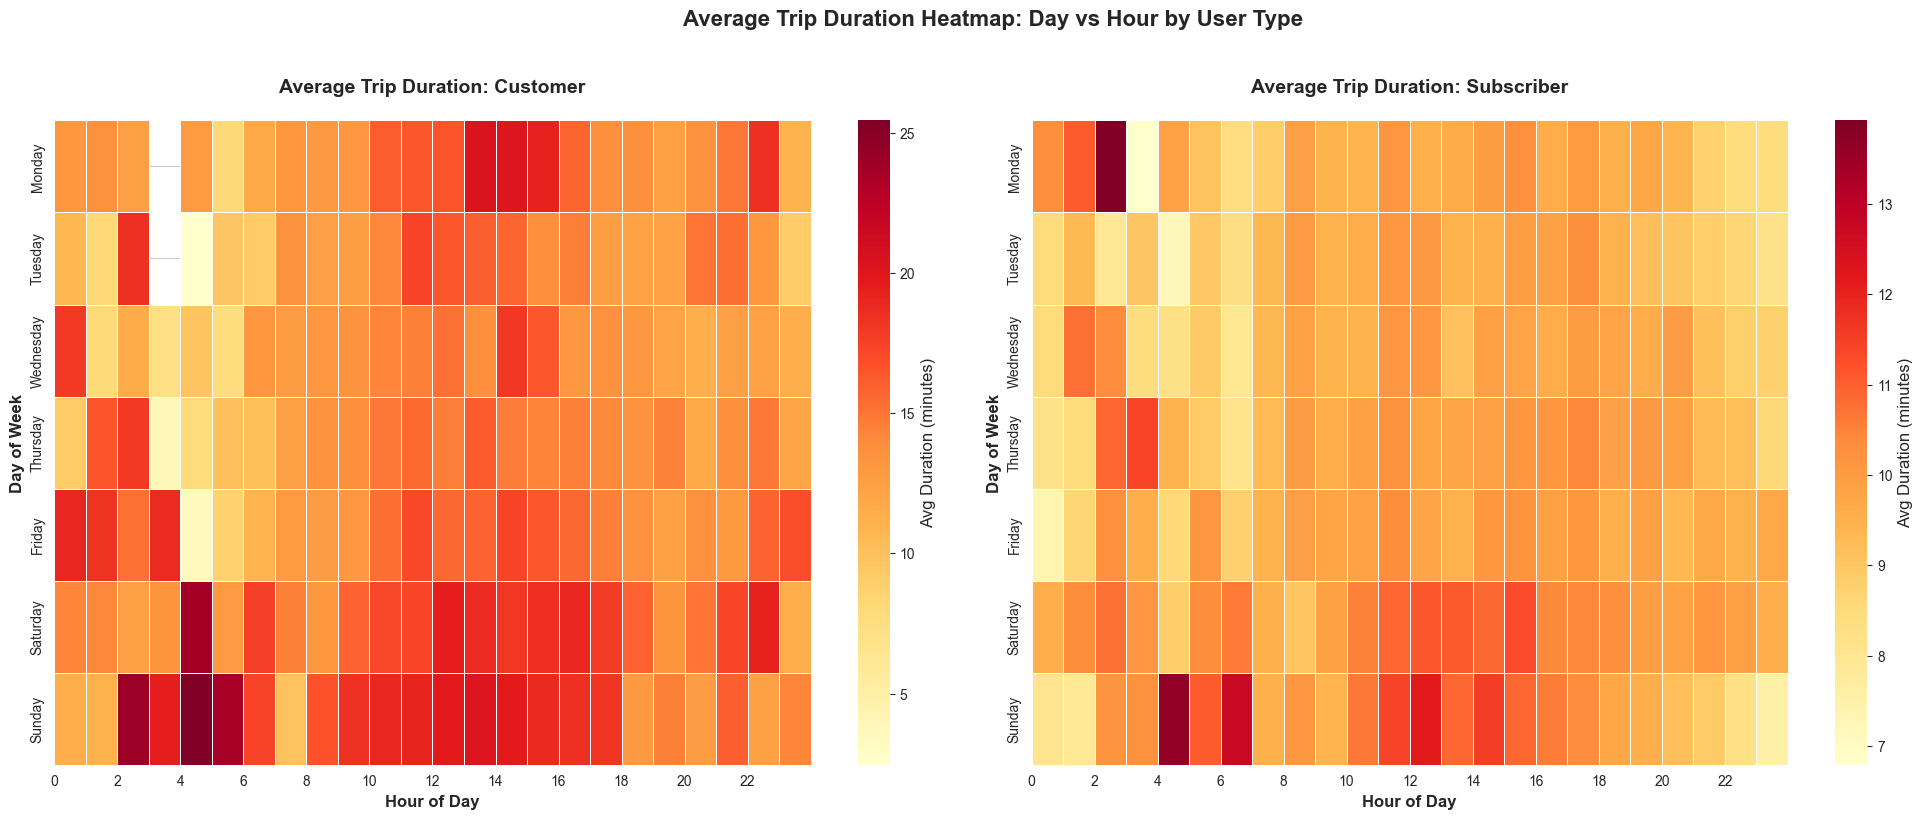

Average Trip Duration Summary:
Subscribers - Overall: 9.8 min
Customers - Overall: 15.2 min

Peak Hour (8 AM) Average Duration:
Subscribers: 9.8 min
Customers: 13.5 min


In [5]:
# Visualization 3: Average Trip Duration Heatmap
df_heat = df_clean.groupby(['start_day_ordered', 'start_hour', 'user_type'])['duration_min'].mean().reset_index()

# Create separate heatmaps for each user type
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for idx, user_type in enumerate(['Customer', 'Subscriber']):
    user_data = df_heat[df_heat['user_type'] == user_type]
    user_pivot = user_data.pivot(index='start_day_ordered', 
                                 columns='start_hour', 
                                 values='duration_min')
    
    sns.heatmap(user_pivot, annot=False, fmt='.1f', cmap='YlOrRd', 
                ax=axes[idx], cbar_kws={'label': 'Avg Duration (minutes)'},
                linewidths=0.5, linecolor='white')
    axes[idx].set_title(f'Average Trip Duration: {user_type}', 
                       fontsize=14, fontweight='bold', pad=20)
    axes[idx].set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Day of Week', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(range(0, 24, 2))
    axes[idx].set_xticklabels(range(0, 24, 2))

plt.suptitle('Average Trip Duration Heatmap: Day vs Hour by User Type', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary statistics
print("Average Trip Duration Summary:")
print(f"Subscribers - Overall: {df_clean[df_clean['user_type']=='Subscriber']['duration_min'].mean():.1f} min")
print(f"Customers - Overall: {df_clean[df_clean['user_type']=='Customer']['duration_min'].mean():.1f} min")
print(f"\nPeak Hour (8 AM) Average Duration:")
print(f"Subscribers: {df_heat[(df_heat['user_type']=='Subscriber') & (df_heat['start_hour']==8)]['duration_min'].mean():.1f} min")
print(f"Customers: {df_heat[(df_heat['user_type']=='Customer') & (df_heat['start_hour']==8)]['duration_min'].mean():.1f} min")


## Visualization 4: User Type Distribution and Usage Share

This visualization shows the composition of Ford GoBike users and their relative usage. While Subscribers make up 89% of users, this visualization also shows their share of total trips, highlighting the dominance of subscription-based usage in the system.


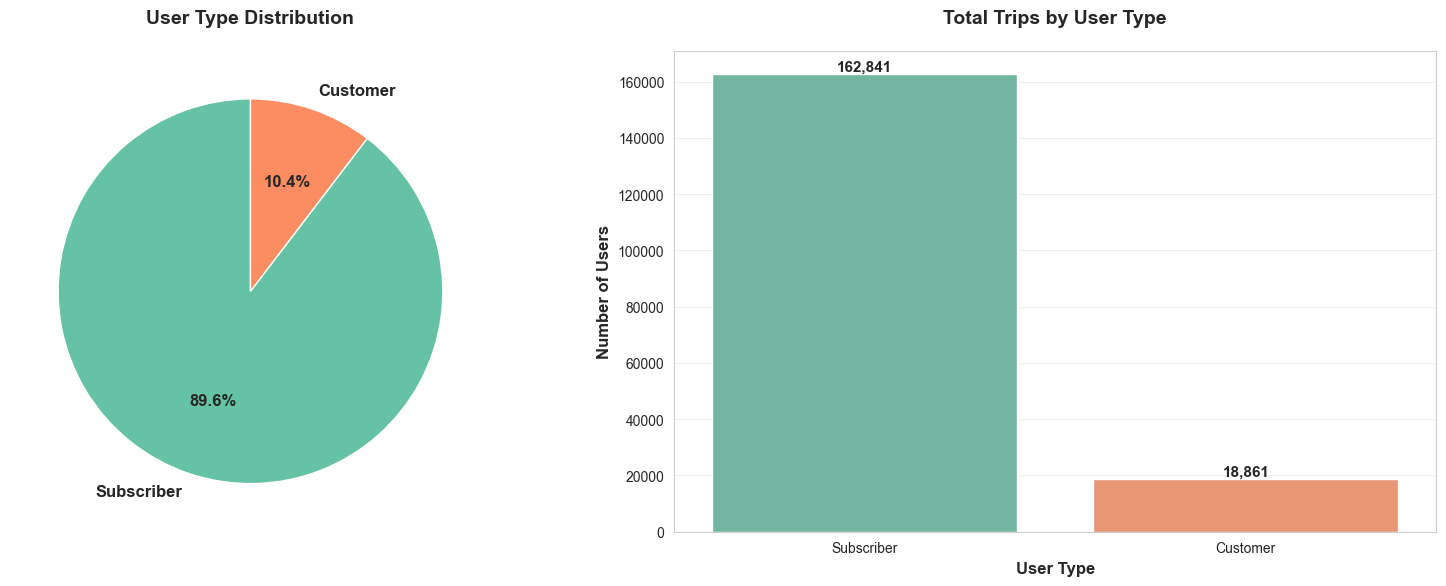

Total trips: 181,702
Subscribers: 162,841 trips (89.6%)
Customers: 18,861 trips (10.4%)


In [6]:
# Visualization 4: User Type Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart for user type distribution
user_type_counts = df_clean['user_type'].value_counts()
colors = ['#66c2a5', '#fc8d62']
wedges, texts, autotexts = axes[0].pie(user_type_counts.values, 
                                       labels=user_type_counts.index,
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90,
                                       textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('User Type Distribution', fontsize=14, fontweight='bold', pad=20)

# Bar chart showing absolute numbers
sns.barplot(x=user_type_counts.index, y=user_type_counts.values, 
            ax=axes[1], palette=colors)
axes[1].set_xlabel('User Type', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Users', fontsize=12, fontweight='bold')
axes[1].set_title('Total Trips by User Type', fontsize=14, fontweight='bold', pad=20)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(user_type_counts.values):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Total trips: {len(df_clean):,}")
print(f"Subscribers: {user_type_counts['Subscriber']:,} trips ({user_type_counts['Subscriber']/len(df_clean)*100:.1f}%)")
print(f"Customers: {user_type_counts['Customer']:,} trips ({user_type_counts['Customer']/len(df_clean)*100:.1f}%)")


## Summary and Key Takeaways

The visualizations reveal clear patterns in Ford GoBike usage:

1. **Two Distinct User Segments**: Subscribers (89%) use bikes for efficient weekday commutes, while Customers (11%) use them for longer leisure trips.

2. **Strong Commute Patterns**: Peak usage at 8 AM and 5-6 PM, with weekdays seeing 3-4x more trips than weekends.

3. **Duration Differences**: Subscribers average ~9 minutes per trip vs Customers' ~15 minutes, reflecting different use cases.

4. **Consistent Patterns**: Subscribers show very consistent, shorter trip durations throughout the week, especially during commute hours.

**Business Implications:**
- Focus bike availability and maintenance during weekday commute hours
- Consider different pricing or service tiers for commuter vs leisure users
- Weekend usage is lower but trips are longer - may need different station distribution
- Subscriber retention is critical as they drive the majority of usage


### Submission
If you are using classroom workspace, you can choose from the following two ways of submission:

1. **Submit from the workspace**. Make sure you have removed the example project from the /home/workspace directory. You must submit the following files:
   - Part_I_notebook.ipynb
   - Part_I_notebook.html or pdf
   - Part_II_notebook.ipynb
   - Part_II_notebook.html or pdf


2. **Submit a zip file on the last page of this project lesson**. In this case, open the Jupyter terminal and run the command below to generate a ZIP file. 
```bash
zip -r my_project.zip .
```
The command abobve will ZIP every file present in your /home/workspace directory. Next, you can download the zip to your local, and follow the instructions on the last page of this project lesson.
